<a href="https://colab.research.google.com/github/laussin86/laussin86/blob/main/Football_Players'_Transfer_Fee_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sn
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score,KFold
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the data

df = pd.read_csv('/content/drive/MyDrive/BCG/final_data.csv')


In [ ]:
# Check the datatypes of the attributes.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10754 entries, 0 to 10753
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   player               10754 non-null  object 
 1   team                 10754 non-null  object 
 2   name                 10754 non-null  object 
 3   position             10754 non-null  object 
 4   height               10754 non-null  float64
 5   age                  10754 non-null  float64
 6   appearance           10754 non-null  int64  
 7   goals                10754 non-null  float64
 8   assists              10754 non-null  float64
 9   yellow cards         10754 non-null  float64
 10  second yellow cards  10754 non-null  float64
 11  red cards            10754 non-null  float64
 12  goals conceded       10754 non-null  float64
 13  clean sheets         10754 non-null  float64
 14  minutes played       10754 non-null  int64  
 15  days_injured         10754 non-null 

In [ ]:
print(df.shape)
display(df.head())

(10754, 22)


,player,team,name,position,height,age,appearance,goals,assists,yellow cards,...,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger
0,/david-de-gea/profil/spieler/59377,Manchester United,David de Gea,Goalkeeper,189.0,32.0,104,0.000000,0.000000,0.009585,...,1.217252,0.335463,9390,42,5,13,15000000,70000000,1,0
1,/jack-butland/profil/spieler/128899,Manchester United,Jack Butland,Goalkeeper,196.0,30.0,15,0.000000,0.000000,0.069018,...,1.242331,0.207055,1304,510,58,1,1500000,22000000,1,0
2,/tom-heaton/profil/spieler/34130,Manchester United,Tom Heaton,Goalkeeper,188.0,37.0,4,0.000000,0.000000,0.000000,...,0.616438,0.924658,292,697,84,4,600000,6000000,1,0
3,/lisandro-martinez/profil/spieler/480762,Manchester United,Lisandro Martínez,Defender Centre-Back,175.0,25.0,82,0.028090,0.056180,0.224719,...,0.000000,0.000000,6408,175,22,9,50000000,50000000,2,0
4,/raphael-varane/profil/spieler/164770,Manchester United,Raphaël Varane,Defender Centre-Back,191.0,30.0,63,0.017889,0.017889,0.053667,...,0.000000,0.000000,5031,238,51,21,40000000,80000000,2,0


# Preprocessing and EDA

In [ ]:
# Are there any missing values in the dataset?
df.isnull().sum()

player                 0
team                   0
name                   0
position               0
height                 0
age                    0
appearance             0
goals                  0
assists                0
yellow cards           0
second yellow cards    0
red cards              0
goals conceded         0
clean sheets           0
minutes played         0
days_injured           0
games_injured          0
award                  0
current_value          0
highest_value          0
position_encoded       0
winger                 0
dtype: int64

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
height,10754.0,1.812404e+02,6.969818e+00,156.0,176.000000,1.812404e+02,1.860000e+02,2.060000e+02
age,10754.0,2.604190e+01,4.777629e+00,15.0,22.000000,2.600000e+01,2.900000e+01,4.300000e+01
appearance,10754.0,3.640701e+01,2.652654e+01,0.0,12.000000,3.500000e+01,5.900000e+01,1.070000e+02
goals,10754.0,1.255543e-01,2.355851e-01,0.0,0.000000,4.596918e-02,1.722625e-01,1.125000e+01
assists,10754.0,8.697765e-02,1.433513e-01,0.0,0.000000,4.077323e-02,1.331361e-01,4.000000e+00
yellow cards,10754.0,1.897572e-01,4.323879e-01,0.0,0.053191,1.502504e-01,2.482759e-01,3.000000e+01
second yellow cards,10754.0,4.665667e-03,2.523200e-02,0.0,0.000000,0.000000e+00,0.000000e+00,1.000000e+00
red cards,10754.0,6.826070e-03,8.114266e-02,0.0,0.000000,0.000000e+00,0.000000e+00,6.923077e+00
goals conceded,10754.0,1.316555e-01,4.423355e-01,0.0,0.000000,0.000000e+00,0.000000e+00,9.000000e+00
clean sheets,10754.0,4.488090e-02,9.244373e-01,0.0,0.000000,0.000000e+00,0.000000e+00,9.000000e+01


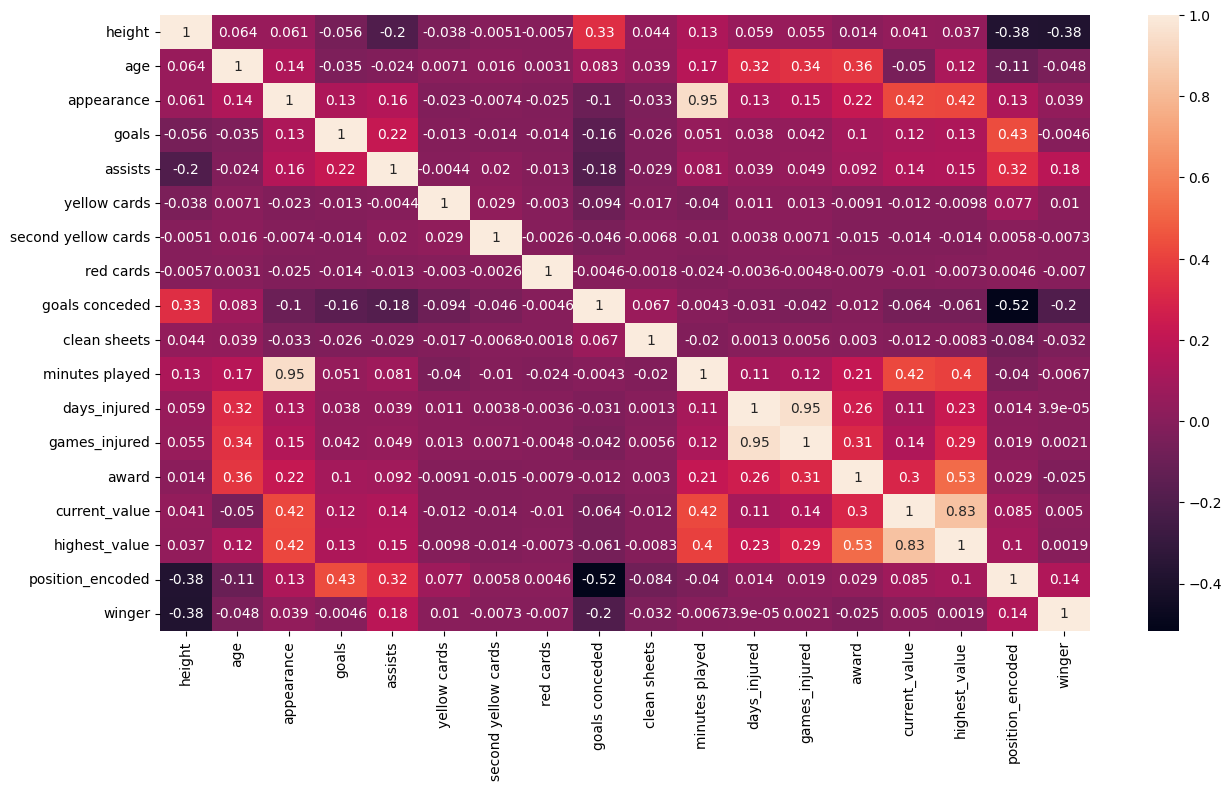

In [ ]:
# correlation matrix
plt.figure(figsize=(15, 8))
numeric_df = df.select_dtypes(include=['int64', 'float64'])
corrMatrix = numeric_df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

We can notice the features with strongest correlation with current_value with exception of highest value are appearance and minutes played followed by award with correlation around 0.4. The 2 next features with positive correlation with current price are # goals,assists,days_injured and games_injured. It can be explained by the fact that players values are tied to player performances.



In [ ]:
df['goal+assists']=df['goals']+df['assists']
df['Minutes per Game']=df['minutes played']/df['appearance']
df['Value Change']=df['current_value']-df['highest_value']

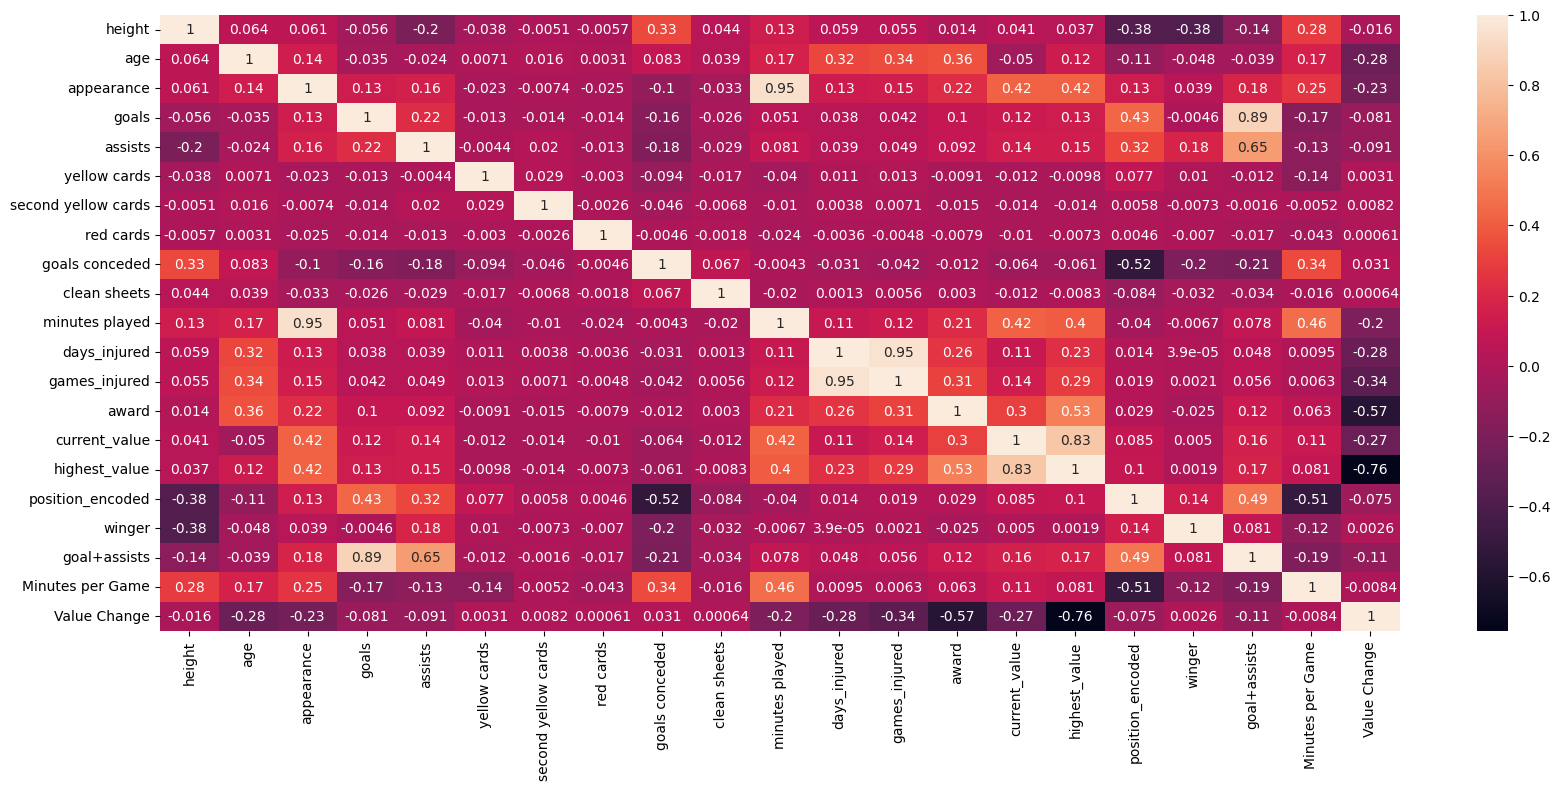

In [ ]:
plt.figure(figsize=(20, 8))
numeric_df = df.select_dtypes(include=['int64', 'float64'])
corrMatrix = numeric_df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [ ]:
df=df.drop(columns=['team','player','name','position_encoded','winger'],errors='ignore')

In [ ]:
df.isnull().sum()

position                 0
height                   0
age                      0
appearance               0
goals                    0
assists                  0
yellow cards             0
second yellow cards      0
red cards                0
goals conceded           0
clean sheets             0
minutes played           0
days_injured             0
games_injured            0
award                    0
current_value            0
highest_value            0
goal+assists             0
Minutes per Game       389
Value Change             0
dtype: int64

In [ ]:
df['Minutes per Game'].fillna(df['Minutes per Game'].median(),inplace=True)

<ipython-input-177-aae08362d1b5>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.set_xticklabels(['Players current value'], fontsize=12, ha="center")


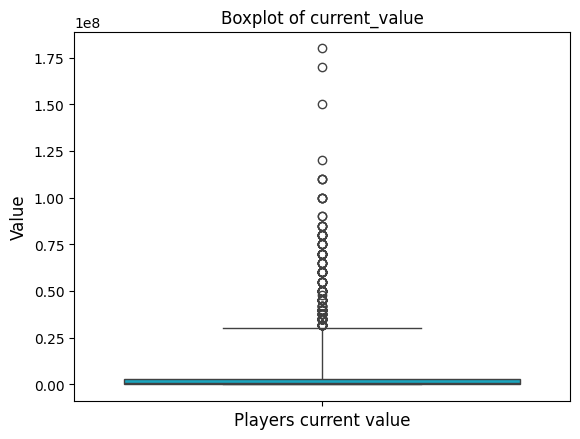

In [ ]:
# Target Variable Distribution
fig= sns.boxplot(df['current_value'], whis=10, color="#00B8D9")
plt.title("Boxplot of current_value")
plt.ylabel("Value", fontsize=12)
fig.set_xticklabels(['Players current value'], fontsize=12, ha="center")
plt.show()


<ipython-input-63-220e66e6d967>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['current_value'], kde=False,


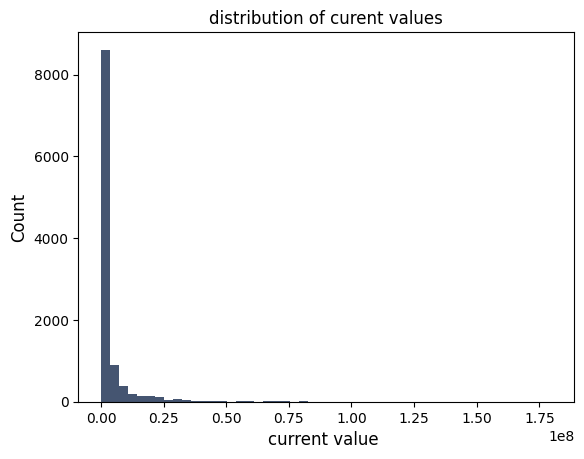

In [ ]:
sns.distplot(df['current_value'], kde=False,
             color="#172B4D", hist_kws={"alpha": 0.8});
plt.title("distribution of curent values")
plt.xlabel("current value ", fontsize=12)
plt.ylabel("Count", fontsize=12);

**With the histogram we can see that it is skewed on the right meaning most of the value are between 0 to 25,000,000**

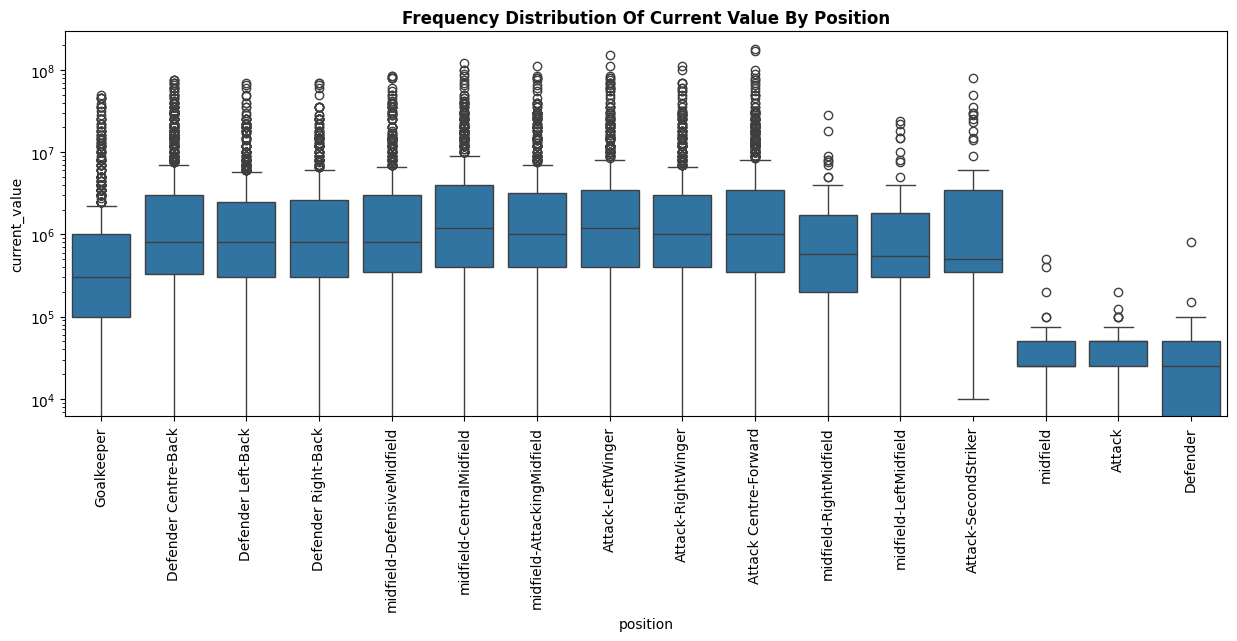

In [ ]:
plt.figure(figsize=(15,5))
plt.title('Frequency Distribution Of Current Value By Position',fontweight='bold')
sns.boxplot(df,x='position',y='current_value')
plt.yscale('log')
plt.xticks(rotation=90)
plt.show()

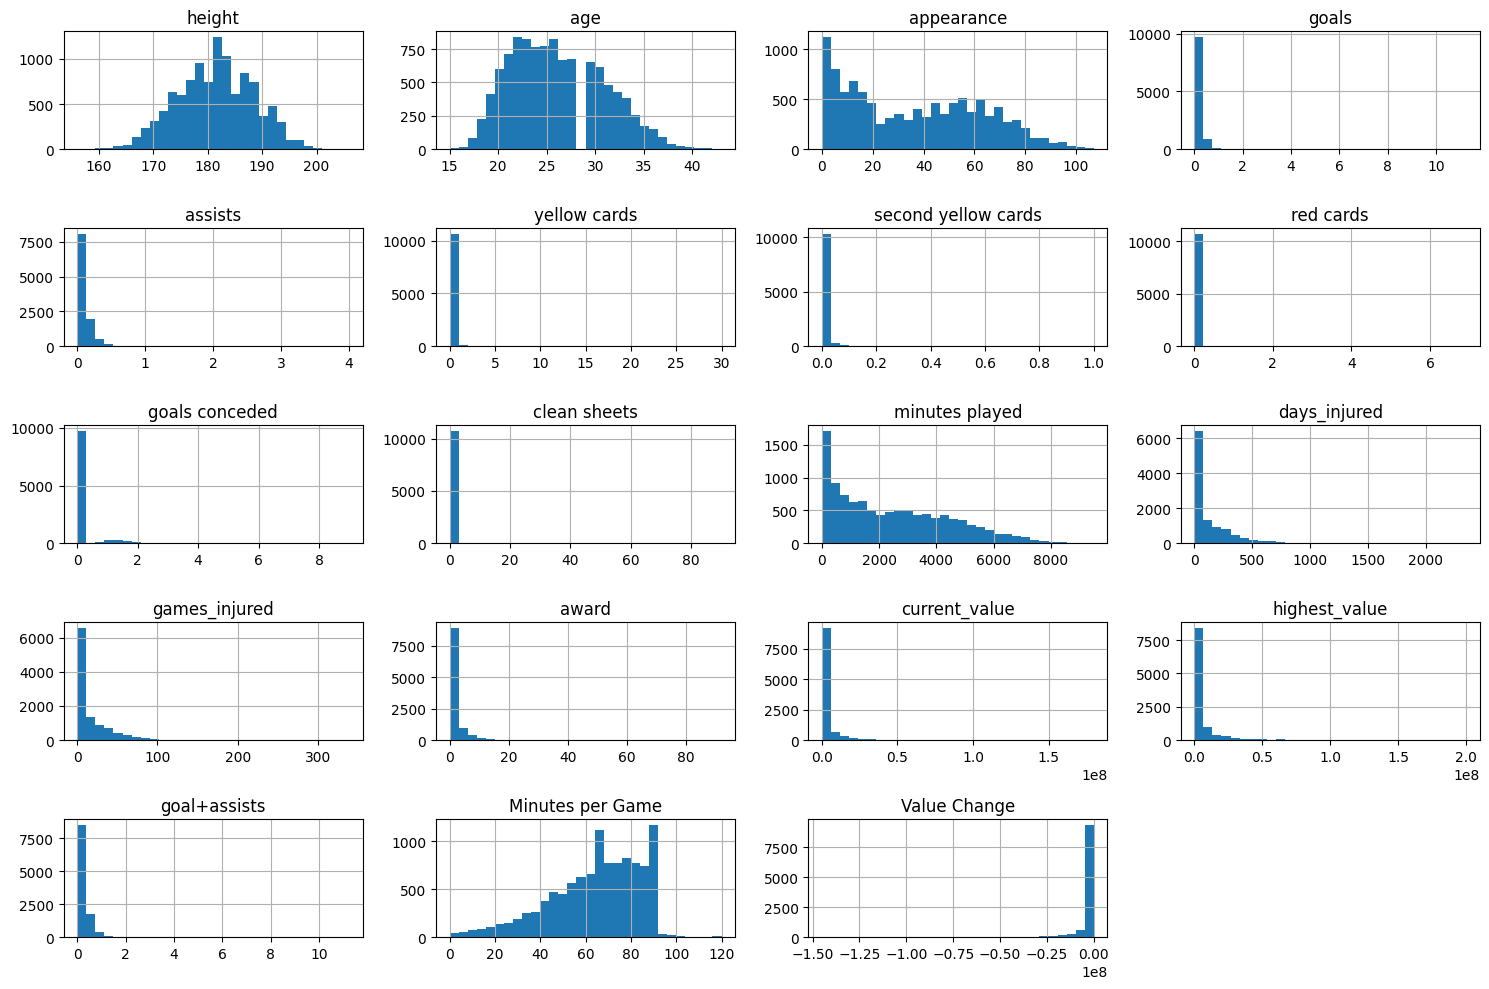

In [ ]:
df.hist(figsize=(15,10),bins=30)
plt.tight_layout()
plt.show()

In [ ]:
#one hot-encoding
df = pd.get_dummies(df)

In [ ]:
display(df.head())

,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,...,position_Defender Centre-Back,position_Defender Left-Back,position_Defender Right-Back,position_Goalkeeper,position_midfield,position_midfield-AttackingMidfield,position_midfield-CentralMidfield,position_midfield-DefensiveMidfield,position_midfield-LeftMidfield,position_midfield-RightMidfield
0,189.0,32.0,104,0.000000,0.000000,0.009585,0.0,0.0,1.217252,0.335463,...,False,False,False,True,False,False,False,False,False,False
1,196.0,30.0,15,0.000000,0.000000,0.069018,0.0,0.0,1.242331,0.207055,...,False,False,False,True,False,False,False,False,False,False
2,188.0,37.0,4,0.000000,0.000000,0.000000,0.0,0.0,0.616438,0.924658,...,False,False,False,True,False,False,False,False,False,False
3,175.0,25.0,82,0.028090,0.056180,0.224719,0.0,0.0,0.000000,0.000000,...,True,False,False,False,False,False,False,False,False,False
4,191.0,30.0,63,0.017889,0.017889,0.053667,0.0,0.0,0.000000,0.000000,...,True,False,False,False,False,False,False,False,False,False


# Model Building and Evaluation

In [ ]:
df.dtypes.value_counts()

bool       16
float64    11
int64       8
Name: count, dtype: int64

In [ ]:
# lets first check the final dimension of our dataset after the preprocessing step
df.shape

(10754, 35)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('current_value', axis=1), df[['current_value']],
    test_size=0.20, random_state=3)

In [ ]:
scaler = StandardScaler()
# We need to fit the scaler to our data before transformation
df.loc[:, df.columns != 'current_value'] = scaler.fit_transform(df.loc[:, df.columns != 'current_value'])


We will use GridSearchCV() to search for the best model parameters in a parameter space provided by us.
 - The parameter "max_depth" sets the maximum depth of a tree,

 -  "learning_rate" represents the step size shrinkage used in updating weights,

 - "n_estimators" specifies the number of boosted trees to fit,

 - "booster" determines which booster to use,
 - "gamma" specifies the minimum loss reduction required to make a further partition on a leaf node of the tree,
 - "subsample" is subsample ratio of the training instances; this subsampling will occur once in every boosting iteration,
 - "colsample_bytree" specifies the subsample ratio of columns when constructing each tree,
 - "colsample_bylevel" specifies the subsample ratio of columns for each split, in each level,
 - "reg_alpha" is L1 regularization term, and
 - "reg_lambda" is L2 regularization term.


In [ ]:
parameter_space = \
    {
        "max_depth": [4, 5, 6],
        "learning_rate": [0.005, 0.009, 0.01],
        "n_estimators": [700, 1000, 2500],
        "booster": ["gbtree",],
        "gamma": [7, 25, 100],
        "subsample": [0.3, 0.6],
        "colsample_bytree": [0.5, 0.7],
        "colsample_bylevel": [0.5, 0.7,],
        "reg_alpha": [1, 10, 33],
        "reg_lambda": [1, 3, 10],
    }

clf = RandomizedSearchCV(XGBRegressor(random_state=3),
                         parameter_space, cv=5, n_jobs=4,
                         scoring="neg_mean_absolute_error",
                         random_state=3, n_iter=10)

clf.fit(X_train, y_train)
print("Best parameters:")
print(clf.best_params_)

Best parameters:
{'subsample': 0.6, 'reg_lambda': 10, 'reg_alpha': 10, 'n_estimators': 2500, 'max_depth': 4, 'learning_rate': 0.009, 'gamma': 7, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'booster': 'gbtree'}


In [ ]:
model = XGBRegressor(**clf.best_params_)

In [ ]:
xgb_model= model.fit(X_train, y_train);

In [ ]:
y_pred = model.predict(X_test)
xgb_mae = mean_absolute_error(y_test, y_pred)
print("XGBoost MAE =", xgb_mae)

XGBoost MAE = 502358.5967542009


I chose the mean absolute error (MAE) as our performance metric to evaluate and compare models. MAE presents a value that is easy to understand; it shows the average value of model error. For example, for our XGBoost model, its MAE is 502,358.59 which means that on average, XGBoost will predict a value that is bigger or smaller than the true value by that amount. Now to understand how good this MAE is, we need to know the range and distribution of the data.

In [ ]:
y_train.describe(include=[np.number])

,current_value
count,8.603000e+03
mean,3.595575e+06
std,8.913129e+06
min,0.000000e+00
25%,3.000000e+05
50%,8.000000e+05
75%,2.800000e+06
max,1.800000e+08


We can see that the mean is 3,595,575 and the median is 800,000. We can see also that the first quartile is 300,000; this means that 75% of the data is larger than this number.Now looking at XGBoost error of  502,358.59, we can say that an error of about  502,358.59 is good for us for data whose mean is 3,595,575 and whose 75% of it is larger than 300,000.

# Feature Importances

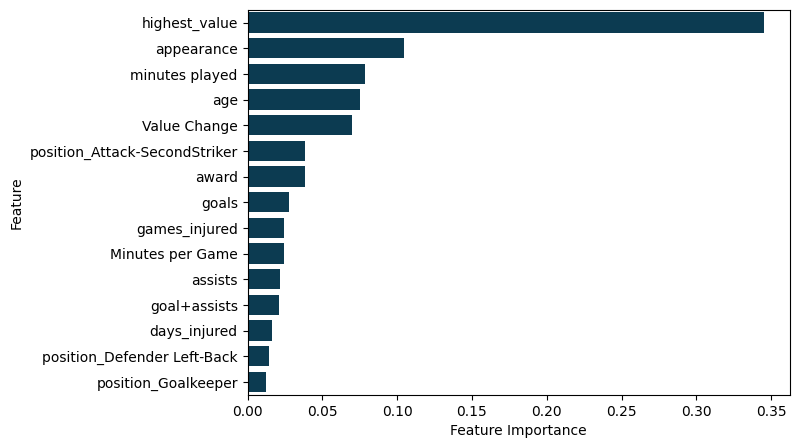

In [ ]:

xgb_feature_importances = model.feature_importances_
xgb_feature_importances = pd.Series(
    xgb_feature_importances, index=X_train.columns.values
    ).sort_values(ascending=False).head(15)

fig, ax = plt.subplots(figsize=(7, 5))
sns.barplot(x=xgb_feature_importances,
            y=xgb_feature_importances.index,
            color="#003f5c");
plt.xlabel('Feature Importance');
plt.ylabel('Feature');

we can see that highest_value, appearance, age and minutes played respectively were the most important features to predict the the player current value.

In [ ]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(model):
    train_sizes,train_scores,test_scores=learning_curve(
        X=X_train,
        y=y_train,
        estimator=model,
        train_sizes=np.linspace(0.1,1,10),
        cv=3,
        scoring='neg_root_mean_squared_error',
        #verbose=1
    )

    train_scores_mean=np.mean(train_scores,axis=1)
    train_scores_std=np.std(train_scores,axis=1)
    test_scores_mean=np.mean(test_scores,axis=1)
    test_scores_std=np.std(test_scores,axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, label='Training Accuracy', color='blue')
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color='blue')
    plt.plot(train_sizes, test_scores_mean, label='Validation Accuracy', color='red')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color='red')
    plt.xlabel('Training Set Size')
    plt.ylabel('MAE')
    plt.title('Learning Curve')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

In [ ]:
plot_learning_curve(model)

KeyboardInterrupt: 

In [ ]:
train_prediction=model.predict(X_train)
test_prediction=model.predict(X_test)

In [ ]:


r2_train=metrics.r2_score(train_prediction,y_train)
r2_test=metrics.r2_score(test_prediction,y_test)
mae_train=metrics.mean_absolute_error(train_prediction,y_train)
mae_test=metrics.mean_absolute_error(test_prediction,y_test)
rmse_train=metrics.mean_squared_error(train_prediction,y_train,squared=False)
rmse_test=metrics.mean_squared_error(test_prediction,y_test,squared=False)
train_scores={'R2_train':r2_train,'MAE_train':mae_train,'RMSE_train':rmse_train}
test_scores={'R2_test':r2_test,'MAE_test':mae_test,'RMSE_test':rmse_test}
print(train_scores)
print(test_scores)

{'R2_train': 0.993431518866977, 'MAE_train': 351482.75388424244, 'RMSE_train': 707694.3280708678}
{'R2_test': 0.9670186370831712, 'MAE_test': 502358.5967542009, 'RMSE_test': 1675561.2877457885}


In [ ]:
#Gradient Boosting Regressor model
from sklearn import ensemble

params = {'n_estimators':500, 'max_depth':4, 'min_samples_split':2,'learning_rate': 0.01, 'loss':'squared_error'}
regressor = ensemble.GradientBoostingRegressor(**params)
regressor.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(learning_rate=0.01, max_depth=4, n_estimators=500)

In [ ]:
y_pred = regressor.predict(X_test)

In [ ]:
train_prediction_Gradient=regressor.predict(X_train)

In [ ]:
r2_train=metrics.r2_score(train_prediction_Gradient,y_train)
r2_test=metrics.r2_score(y_pred,y_test)
mae_train=metrics.mean_absolute_error(train_prediction_Gradient,y_train)
mae_test=metrics.mean_absolute_error(y_pred,y_test)
rmse_train=metrics.mean_squared_error(train_prediction_Gradient,y_train,squared=False)
rmse_test=metrics.mean_squared_error(y_pred,y_test,squared=False)
train_scores={'R2_train':r2_train,'MAE_train':mae_train,'RMSE_train':rmse_train}
test_scores={'R2_test':r2_test,'MAE_test':mae_test,'RMSE_test':rmse_test}
print(train_scores)
print(test_scores)

{'R2_train': 0.9965986186452477, 'MAE_train': 263722.99738345295, 'RMSE_train': 510860.84564678476}
{'R2_test': 0.9869680692234509, 'MAE_test': 335320.28995647375, 'RMSE_test': 1081702.0505894278}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

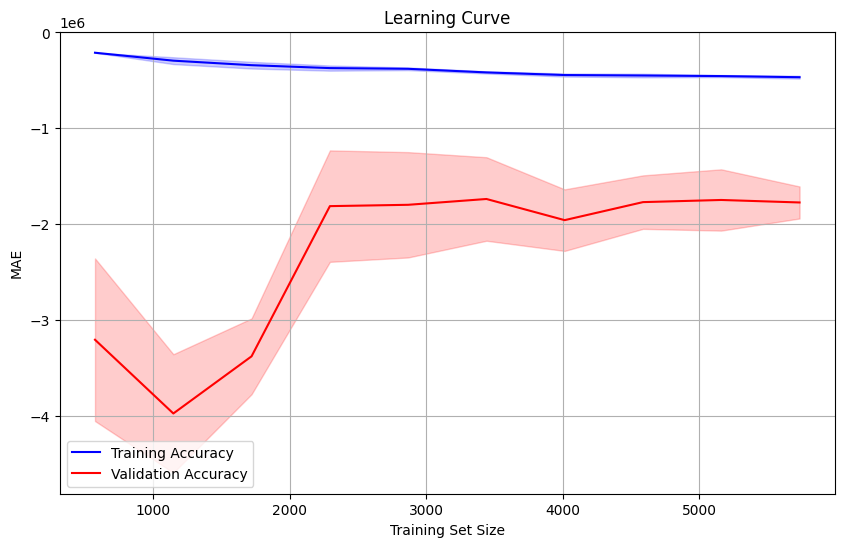

In [ ]:
plot_learning_curve(regressor)

In [ ]:
#Random forest Regressor model
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=100, random_state = 0)
rfr.fit(X_train, y_train)

<ipython-input-201-b93382e3d093>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfr.fit(X_train, y_train)


RandomForestRegressor(random_state=0)

In [ ]:
y_pred = rfr.predict(X_test)

In [ ]:
train_prediction_Forest=rfr.predict(X_train)

In [ ]:
r2_train=metrics.r2_score(train_prediction_Forest,y_train)
r2_test=metrics.r2_score(y_pred,y_test)
mae_train=metrics.mean_absolute_error(train_prediction_Forest,y_train)
mae_test=metrics.mean_absolute_error(y_pred,y_test)
rmse_train=metrics.mean_squared_error(train_prediction_Forest,y_train,squared=False)
rmse_test=metrics.mean_squared_error(y_pred,y_test,squared=False)
train_scores={'R2_train':r2_train,'MAE_train':mae_train,'RMSE_train':rmse_train}
test_scores={'R2_test':r2_test,'MAE_test':mae_test,'RMSE_test':rmse_test}
print(train_scores)
print(test_scores)

{'R2_train': 0.9936253704948035, 'MAE_train': 87985.15634081134, 'RMSE_train': 695174.7593567591}
{'R2_test': 0.9798716578484213, 'MAE_test': 218171.52487215248, 'RMSE_test': 1336420.1069092476}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed whe

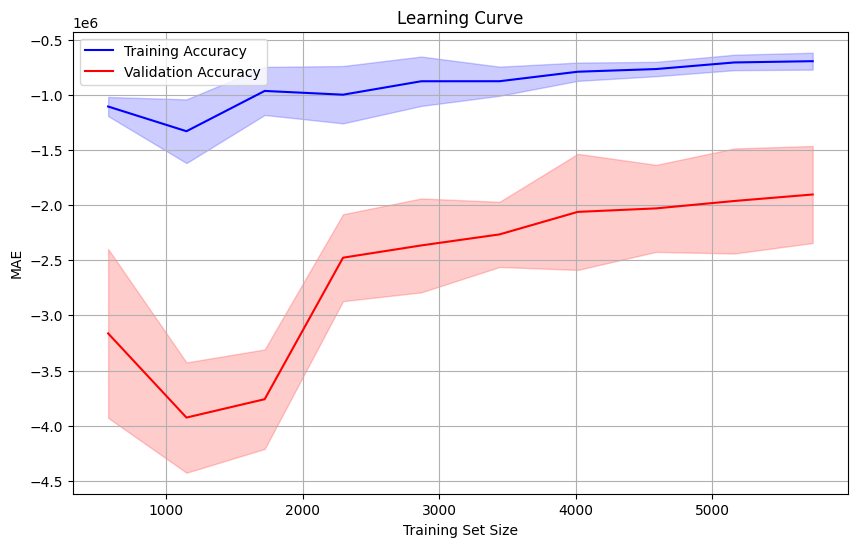

In [ ]:
plot_learning_curve(rfr)